In [2]:
pip install imageio-ffmpeg


Note: you may need to restart the kernel to use updated packages.


In [4]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window

import cv2  # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc  # For saving images as needed
import glob  # For reading in a list of images from a folder
#import imageio
#imageio.plugins.ffmpeg.download()


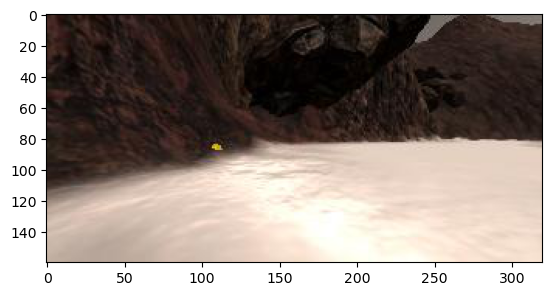

In [5]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)

# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

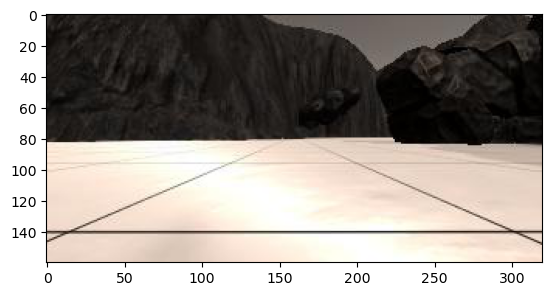

In [7]:
# In the simulator the grid on the ground can be toggled on for calibration.
example_grid = '../calibration_images/example_grid1.jpg'
grid_img = mpimg.imread(example_grid)
plt.imshow(grid_img)
#plt.savefig('grid_img.png')

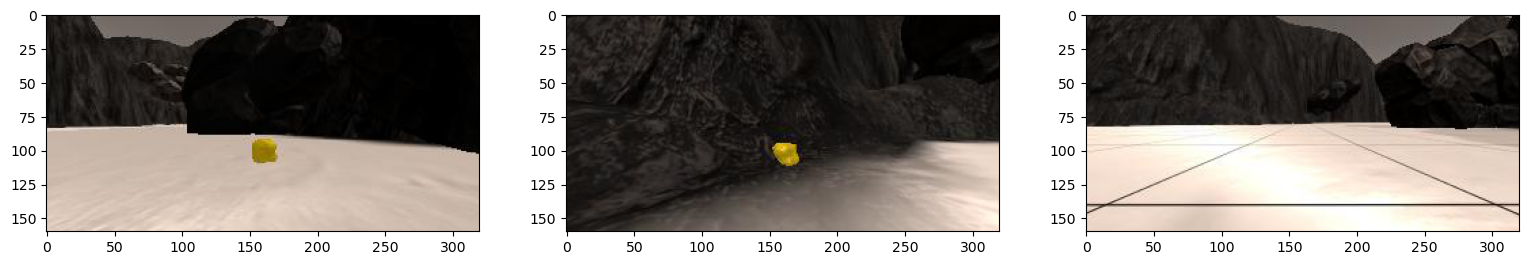

In [8]:
# The rock samples can be toggled on with the 0 (zero) key.
example_rock = '../calibration_images/example_rock1.jpg'
example_rock2 = '../calibration_images/example_rock2.jpg'
example_grid = '../calibration_images/example_grid1.jpg'
rock_img = mpimg.imread(example_rock)
rock_img2 = mpimg.imread(example_rock2)
grid_img = mpimg.imread(example_grid)
fig = plt.figure(figsize=(19,7))
plt.subplot(131)
plt.imshow(rock_img)
plt.subplot(132)
plt.imshow(rock_img2)
plt.subplot(133)
plt.imshow(grid_img)

In [9]:
def perspect_transform(img, src, dst):
   
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


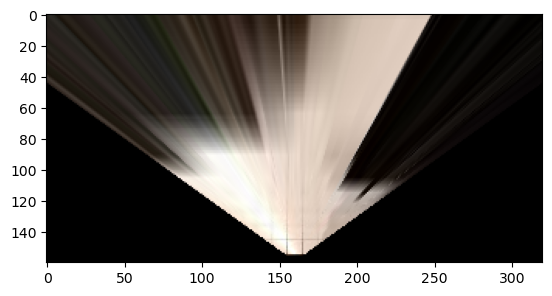

In [16]:
    height, width = grid_img.shape[0], grid_img.shape[1]

    # Numpy array of four source points defining a grid on input 3D image
    # acquired from calibration data in test notebook
    src_x1, src_y1 = 14, 140
    src_x2, src_y2 = 301, 140
    src_x3, src_y3 = 200, 96
    src_x4, src_y4 = 118, 96
    bottom_offset = 5
    dst_grid = 10
    # Corresponding destination points on output 2D overhead image
    dst_x1, dst_y1 = (width/2 - dst_grid/2), (height-bottom_offset)
    dst_x2, dst_y2 = (width/2 + dst_grid/2), (height-bottom_offset)
    dst_x3, dst_y3 = (width/2 + dst_grid/2), (height-dst_grid-bottom_offset)
    dst_x4, dst_y4 = (width/2 - dst_grid/2), (height-dst_grid-bottom_offset)

    src = np.float32([[src_x1, src_y1],
                                [src_x2, src_y2],
                                [src_x3, src_y3],
                                [src_x4, src_y4]])

    dst = np.float32([[dst_x1, dst_y1],
                                [dst_x2, dst_y2],
                                [dst_x3, dst_y3],
                                [dst_x4, dst_y4]])  
    
    # 2) Apply perspective transform
    warped_img = perspect_transform(grid_img,src,dst)
    plt.imshow(warped_img)

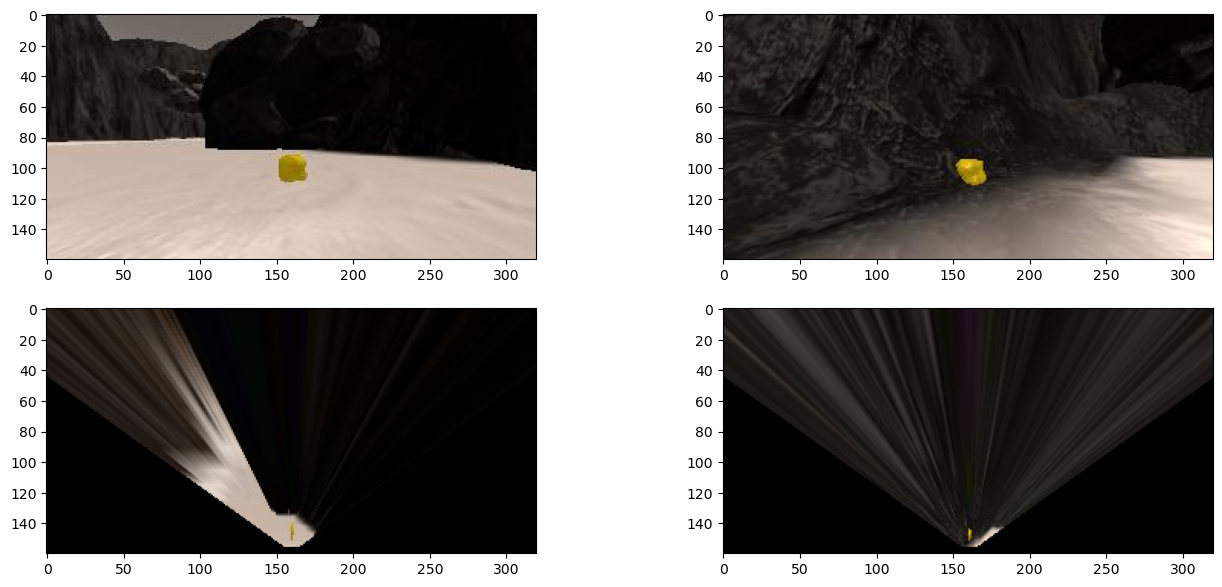

In [17]:
warped_rock = perspect_transform(rock_img,src,dst)
warped_rock2 = perspect_transform(rock_img2,src,dst)

fig = plt.figure(figsize=(16,7))

plt.subplot(221)
plt.imshow(rock_img)

plt.subplot(222)
plt.imshow(rock_img2)

plt.subplot(223)
plt.imshow(warped_rock)

plt.subplot(224)
plt.imshow(warped_rock2)

In [18]:
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

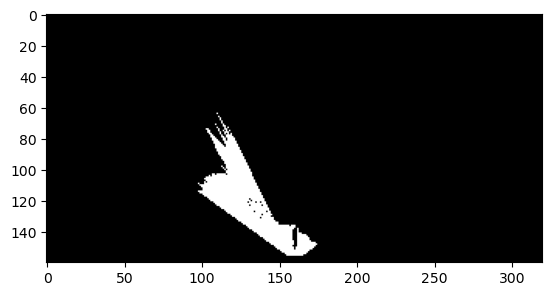

In [19]:
threshed_nav = color_thresh(warped_rock)
plt.imshow(threshed_nav, cmap='gray')

In [31]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float64)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float64)
    return x_pixel, y_pixel
# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel*2 + y_pixel*2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

In [32]:
# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image,src,dst)
threshed = color_thresh(warped)

In [33]:
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

/tmp/ipykernel_11899/3089893637.py:14: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt(x_pixel*2 + y_pixel*2)


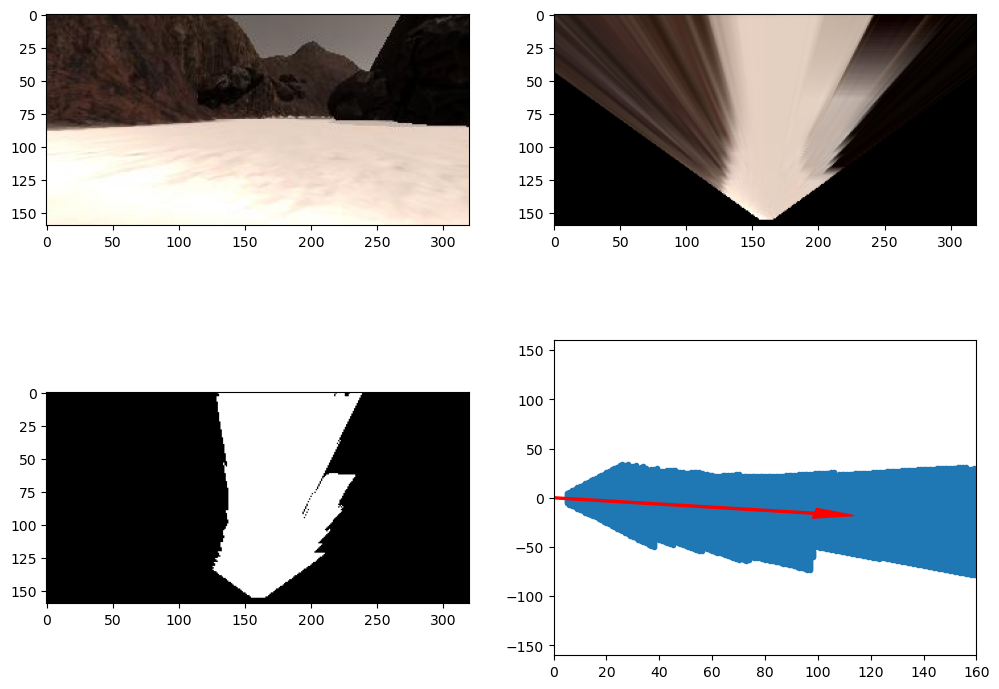

In [35]:
# Do some plotting
fig = plt.figure(figsize=(12,9))

plt.subplot(221)
plt.imshow(image)

plt.subplot(222)
plt.imshow(warped)

plt.subplot(223)
plt.imshow(threshed, cmap='gray')

plt.subplot(224)
plt.plot(xpix, ypix, '.')

plt.ylim(-160, 160)
plt.xlim(0, 160)

arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)

plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)


In [45]:
# Apply the above functions in succession and update the Rover state accordingly
def perception_step(Rover):
    # Perform perception steps to update Rover()
    # TODO: 
    # NOTE: camera image is coming to you in Rover.img
    
    # 1) Define source and destination points for perspective transform
     # Dimension of source image from rover camera
    height, width = Rover.shape[0], Rover.shape[1]

    # Numpy array of four source points defining a grid on input 3D image
    # acquired from calibration data in test notebook
    src_x1, src_y1 = 14, 140
    src_x2, src_y2 = 301, 140
    src_x3, src_y3 = 200, 96
    src_x4, src_y4 = 118, 96
    bottom_offset = 5
    dst_grid = 6
    # Corresponding destination points on output 2D overhead image
    dst_x1, dst_y1 = (width/2 - dst_grid/2), (height-bottom_offset)
    dst_x2, dst_y2 = (width/2 + dst_grid/2), (height-bottom_offset)
    dst_x3, dst_y3 = (width/2 + dst_grid/2), (height-dst_grid-bottom_offset)
    dst_x4, dst_y4 = (width/2 - dst_grid/2), (height-dst_grid-bottom_offset)

    src = np.float32([[src_x1, src_y1],
                                [src_x2, src_y2],
                                [src_x3, src_y3],
                                [src_x4, src_y4]])

    dst = np.float32([[dst_x1, dst_y1],
                                [dst_x2, dst_y2],
                                [dst_x3, dst_y3],
                                [dst_x4, dst_y4]])  
    
    # 2) Apply perspective transform
    warped_img = perspect_transform(Rover,src,dst)
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    thresh_pixpts_pf = color_thresh(warped_img)
    # 4) Update Rover.vision_image (this will be displayed on left side of screen)
        # Example: Rover.vision_image[:,:,0] = obstacle color-thresholded binary image
        #          Rover.vision_image[:,:,1] = rock_sample color-thresholded binary image
        #          Rover.vision_image[:,:,2] = navigable terrain color-thresholded binary image
    ################
    # 5) Convert map image pixel values to rover-centric coords
    x_pixpts_rf, y_pixpts_rf = rover_coords(thresh_pixpts_pf)
    dist, angles = to_polar_coords(x_pixpts_rf, y_pixpts_rf)
    # 6) Convert rover-centric pixel values to world coordinates
    worldmap = np.zeros((200, 200))
    scale = 10  # scale factor assumed between world and rover space pixels
    
    x_world, y_world = pix_to_world(x_pixpts_rf, y_pixpts_rf, Rover.pos[0],Rover.pos[1],Rover.yaw,worldmap.shape[0],scale)

    # 7) Update Rover worldmap (to be displayed on right side of screen)
        # Example: Rover.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          Rover.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          Rover.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    if ((Rover.pitch < 1 or Rover.pitch > 359) and (Rover.roll < 1 or Rover.roll > 359)):
        Rover.worldmap[y_world, x_world, 0] = 0
        Rover.worldmap[y_world,x_world, 2] = 255           
    
    # 8) Convert rover-centric pixel positions to polar coordinates
    # Update Rover pixel distances and angles
        # Rover.nav_dists = rover_centric_pixel_distances
        # Rover.nav_angles = rover_centric_angles
    Rover.dists = dist 
    Rover.angles = angels   
    
    return Rover

In [47]:
x = perception_step(image)
plt.imshow(image)

/tmp/ipykernel_11899/3089893637.py:14: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt(x_pixel*2 + y_pixel*2)


AttributeError: 'numpy.ndarray' object has no attribute 'pos'

In [49]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [50]:
import io
import base64
output = '../output/test_mapping.mp4'
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))